In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion() 

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}




In [3]:
data_dir = 'hymenoptera'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

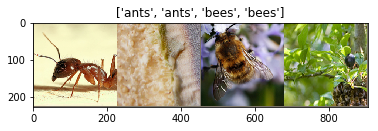

In [4]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train() 
            else:
                model.eval()   
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)                   
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))           
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

In [6]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [7]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5612 Acc: 0.7541
val Loss: 0.7779 Acc: 0.7451

Epoch 1/24
----------
train Loss: 0.6418 Acc: 0.7541
val Loss: 0.3084 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.5778 Acc: 0.7500
val Loss: 0.4347 Acc: 0.8562

Epoch 3/24
----------
train Loss: 0.8242 Acc: 0.7172
val Loss: 1.2460 Acc: 0.6209

Epoch 4/24
----------
train Loss: 0.5793 Acc: 0.8115
val Loss: 0.3022 Acc: 0.8954

Epoch 5/24
----------
train Loss: 0.6915 Acc: 0.8115
val Loss: 0.3172 Acc: 0.8824

Epoch 6/24
----------
train Loss: 0.4739 Acc: 0.8361
val Loss: 0.3759 Acc: 0.8889

Epoch 7/24
----------
train Loss: 0.4801 Acc: 0.8279
val Loss: 0.2739 Acc: 0.9150

Epoch 8/24
----------
train Loss: 0.4204 Acc: 0.8525
val Loss: 0.2635 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.3674 Acc: 0.8811
val Loss: 0.2681 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.3631 Acc: 0.8730
val Loss: 0.2688 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.4101 Acc: 0.8279
val Loss: 0.2412 Acc: 0.9020

Ep

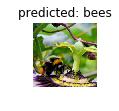

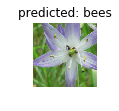

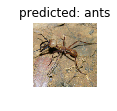

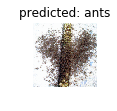

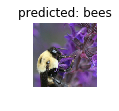

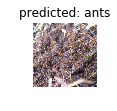

In [9]:
visualize_model(model_ft)

In [10]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
 
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [11]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.6701 Acc: 0.6148
val Loss: 0.3552 Acc: 0.8301

Epoch 1/24
----------
train Loss: 0.4682 Acc: 0.8074
val Loss: 0.2155 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.3620 Acc: 0.8361
val Loss: 0.1974 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.3538 Acc: 0.8443
val Loss: 0.1931 Acc: 0.9412

Epoch 4/24
----------
train Loss: 0.3676 Acc: 0.8361
val Loss: 0.2228 Acc: 0.9216

Epoch 5/24
----------
train Loss: 0.3963 Acc: 0.7951
val Loss: 0.1746 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.4407 Acc: 0.8074
val Loss: 0.1799 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.3496 Acc: 0.8607
val Loss: 0.1784 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3816 Acc: 0.8156
val Loss: 0.1727 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.3701 Acc: 0.8361
val Loss: 0.1742 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3223 Acc: 0.8648
val Loss: 0.1839 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.3911 Acc: 0.8279
val Loss: 0.2355 Acc: 0.9150

Ep

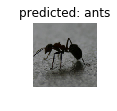

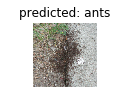

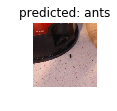

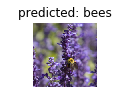

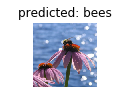

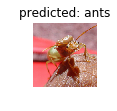

In [12]:
visualize_model(model_conv)
plt.ioff()
plt.show()